In [13]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import sklearn
import skimage.transform
import keras
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop


In [3]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

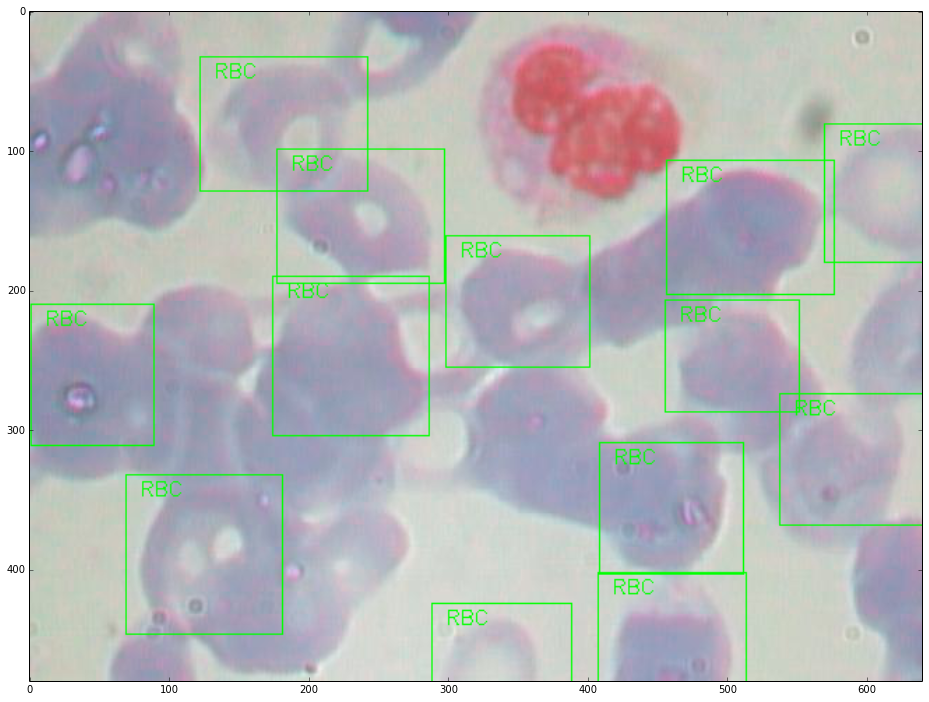

In [23]:
image = cv2.imread("./dataset/dataset-master/JPEGImages/BloodImage_00018.jpg")
tree = ET.parse("./dataset/dataset-master/Annotations/BloodImage_00018.xml")
color = {}
color["R"] = [0, 255, 0]
color["W"] = [0, 0, 255]
color["P"] = [255, 0, 0]
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                cv2.rectangle(image, (xmin, ymin),
                            (xmax, ymax), color[name[0]], 1)
                cv2.putText(image, name, (xmin + 10, ymin + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], color[name[0]], 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

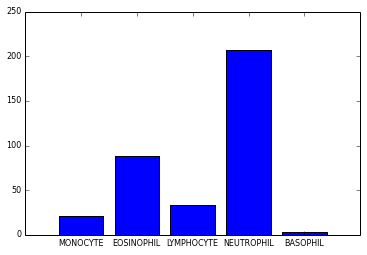

In [26]:
reader = csv.reader(open('./dataset/dataset2-master/labels.csv'))
next(reader)

labels = {
    'BASOPHIL': 0,
    'NEUTROPHIL': 0,
    'EOSINOPHIL': 0,
    'MONOCYTE': 0,
    'LYMPHOCYTE': 0
}
for r in reader:
    curr_label = r[2]
    if len(curr_label) > 0 and len(curr_label) < 11:
        labels[curr_label] += 1

plt.bar(range(len(labels)), labels.values(), width = 0.8, align='center')
plt.xticks(range(len(labels)), labels.keys())
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [11]:
#Since sample size are imbalance for each type, we decide to use the argumented datasets.
def load_argumented_images(path):
    data = []
    
    label1_dict = {
        'NEUTROPHIL': '1',
        'EOSINOPHIL': '2',
        'MONOCYTE': '3',
        'LYMPHOCYTE': '4'
    }
    
    label2_dict = {
        'NEUTROPHIL': '1',
        'EOSINOPHIL': '1',
        'MONOCYTE': '0',
        'LYMPHOCYTE': '0'
    }
    
    for t in label1_dict.keys():
        folder = path + '/' + t
        label1 = label1_dict[t]
        label2 = label2_dict[t]
        for image_name in os.listdir(folder):
            image = cv2.imread(folder+'/'+image_name)
            if image is not None:
                image = scipy.misc.imresize(arr=image, size=(60, 80, 3))
                img_arr = np.asarray(image)
                row = [img_arr, label1, label2]
                data.append(row)
            
    return data
data = load_argumented_images('./dataset/dataset2-master/images/TRAIN')

/Library/Python/2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [198, 208, 202],
        [194, 207, 201],
        [194, 209, 202]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [197, 209, 203],
        [199, 207, 202],
        [202, 208, 203]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [201, 209, 204],
        [202, 207, 202],
        [203, 207, 203]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [  2,   2,   2],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]